In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
data_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/dynamic.h5'
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output'
tf_pairs_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/combinatorial_control/SLIDE_LF_enriched_pair_GC-1_PB-2.csv'
latent_factors_dir = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(data_file)

#### Windows

In [5]:
# Assign window indices for each branch between 0 to 60 (these are relative to S0)
pb_window_indices = list(range(30, 46)) + [2]
abc_window_indices = [1] + list(range(29, 3, -1)) + [0]
gc_window_indices = list(range(46, 61)) + [3]
pb_with_actb_indices = abc_window_indices + pb_window_indices
gc_with_actb_indices = abc_window_indices + gc_window_indices

In [7]:
# read the 2 txt files in latent_factors_dir
latent_factors_file_1 = os.path.join(latent_factors_dir, 'feature_list_Z3.txt')
latent_factors_file_2 = os.path.join(latent_factors_dir, 'feature_list_Z11.txt')
#tab separated files
latent_factors_df_1 = pd.read_csv(latent_factors_file_1, sep='\t')
latent_factors_df_2 = pd.read_csv(latent_factors_file_2, sep='\t')
latent_factors_genes_1 = latent_factors_df_1.iloc[:, 0].tolist()
latent_factors_genes_2 = latent_factors_df_2.iloc[:, 0].tolist()
#create a set of all the genes
latent_factors_genes = list(set(latent_factors_genes_1 + latent_factors_genes_2))
display(len(latent_factors_genes))


68

# Finding dynamically switching modules inside LFs

In [8]:
tfs_in_lfs = check_tf_presence(dictys_dynamic_object, latent_factors_genes)
# targets also contain tfs in latent factors
targets_in_lfs = check_gene_presence(dictys_dynamic_object, latent_factors_genes)
# get the genes not present in the dynamic object
genes_not_in_dynamic_object = [gene for gene in latent_factors_genes if gene not in dictys_dynamic_object.ndict]
display(len(genes_not_in_dynamic_object))
# check if creb3l2 in dynamic object
creb3l2_in_dynamic_object = 'CREB3L2' in dictys_dynamic_object.ndict
display(creb3l2_in_dynamic_object)


11

True

In [33]:
def get_grn_weights_by_adding_tfs_and_targets(dictys_dynamic_object, tf_indices=None, gene_indices=None, window_indices=None, sparsity_threshold=0.3):
    """
    Get the weights matrix for both specified TFs and TFs regulating specified targets,
    after filtering the global GRN by sparsity
    """
    # Get the weights array
    weights = dictys_dynamic_object.prop["es"]["w_n"]
    # Apply sparsity filter to global GRN first
    nonzero_frac = (weights != 0).mean(axis=2)  # shape is (n_tfs, n_targets)
    sparsity_mask = nonzero_frac >= sparsity_threshold
    # Convert indices to lists if they're not already
    tf_indices = list(tf_indices) if tf_indices is not None else []
    gene_indices = list(gene_indices) if gene_indices is not None else []
    # Get all TF indices that regulate the specified target genes (considering sparsity)
    if gene_indices:
        # Only consider edges that pass sparsity filter
        tf_mask = np.any(sparsity_mask[:, gene_indices], axis=1)
        regulating_tf_indices = np.where(tf_mask)[0]
        # Combine with specified TF indices, removing duplicates while preserving order
        all_tf_indices = list(dict.fromkeys(tf_indices + list(regulating_tf_indices)))
    else:
        all_tf_indices = tf_indices
    # Get all gene indices that are regulated by the specified TFs (considering sparsity)
    if tf_indices:
        gene_mask = np.any(sparsity_mask[tf_indices, :], axis=0)
        regulated_gene_indices = np.where(gene_mask)[0]
        # Combine with specified gene indices, removing duplicates while preserving order
        all_gene_indices = list(dict.fromkeys(gene_indices + list(regulated_gene_indices)))
    else:
        all_gene_indices = gene_indices
    # Extract the combined weights matrix using the computed indices
    combined_weights = weights[np.ix_(all_tf_indices, all_gene_indices, window_indices)]
    # Apply sparsity mask to final weights (in case any edges don't meet threshold)
    final_sparsity_mask = sparsity_mask[np.ix_(all_tf_indices, all_gene_indices)]
    combined_weights = np.where(final_sparsity_mask[:, :, np.newaxis], combined_weights, 0)
    return combined_weights, all_tf_indices, all_gene_indices


In [36]:
def get_grn_weights_for_specific_indices(dictys_dynamic_object, tf_indices, gene_indices, window_indices=None, sparsity_threshold=0.3):
    """
    Get the weights matrix for all combinations of specified TFs and target genes,
    after filtering by sparsity.
    
    Parameters:
    -----------
    dictys_dynamic_object : dictys.net.dynamic_network
        Dynamic network object containing the GRN
    tf_indices : list
        List of TF indices to include
    gene_indices : list
        List of target gene indices to include
    window_indices : list, optional
        List of window indices to include. If None, uses all windows
    sparsity_threshold : float
        Minimum fraction of non-zero values required across windows for an edge
    
    Returns:
    --------
    combined_weights : np.ndarray
        Weight matrix for all TF-target combinations (shape: n_tfs x n_targets x n_windows)
    """
    # Get the weights array
    weights = dictys_dynamic_object.prop["es"]["w_n"]
    
    # Convert indices to lists if they're not already
    tf_indices = list(tf_indices)
    gene_indices = list(gene_indices)
    
    # Use all windows if none specified
    if window_indices is None:
        window_indices = list(range(weights.shape[2]))
    
    # Extract weights for all combinations of specified TFs and targets
    combined_weights = weights[np.ix_(tf_indices, gene_indices, window_indices)]
    
    # Calculate sparsity for the extracted weights
    nonzero_frac = (combined_weights != 0).mean(axis=2)  # shape is (n_tfs, n_targets)
    sparsity_mask = nonzero_frac >= sparsity_threshold
    
    # Apply sparsity mask
    combined_weights = np.where(sparsity_mask[:, :, np.newaxis], combined_weights, 0)
    
    # Print some statistics
    print(f"\nWeight Matrix Statistics:")
    print(f"Number of TFs: {len(tf_indices)}")
    print(f"Number of targets: {len(gene_indices)}")
    print(f"Number of windows: {len(window_indices)}")
    print(f"Total possible edges: {len(tf_indices) * len(gene_indices):,}")
    print(f"Edges passing sparsity threshold: {np.sum(sparsity_mask):,}")
    print(f"Max absolute weight: {np.max(np.abs(combined_weights)):.3f}")
    
    return combined_weights

In [39]:
# get indices for tfs and targets (these include tfs in latent factors)
tf_indices_in_lf, tf_gene_indices_in_lf = get_tf_indices(dictys_dynamic_object, tfs_in_lfs)
gene_indices_in_lf = get_target_gene_indices(dictys_dynamic_object, targets_in_lfs)

# print the tf names in latent factors using the gene indices
tf_names_in_lf = [next(k for k, v in dictys_dynamic_object.ndict.items() if v == idx) 
                  for idx in tf_gene_indices_in_lf] 
target_names_in_lf = [next(k for k, v in dictys_dynamic_object.ndict.items() if v == idx) 
                  for idx in gene_indices_in_lf] 
display(tf_names_in_lf)
display(len(target_names_in_lf))

[np.str_('RUNX2'),
 np.str_('PRDM1'),
 np.str_('PAX5'),
 np.str_('XBP1'),
 np.str_('IRF4')]

57

In [32]:
# Get weights and indices for both branches
lf_pb_weights, all_tf_indices_pb, all_gene_indices_pb = get_grn_weights_by_adding_tfs_and_targets(
    dictys_dynamic_object, 
    tf_indices_in_lf, 
    gene_indices_in_lf, 
    window_indices=pb_window_indices, 
    sparsity_threshold=0.1
)

lf_gc_weights, all_tf_indices_gc, all_gene_indices_gc = get_grn_weights_by_adding_tfs_and_targets(
    dictys_dynamic_object, 
    tf_indices_in_lf, 
    gene_indices_in_lf, 
    window_indices=gc_window_indices, 
    sparsity_threshold=0.1
)

all_tf_names = [next(k for k, v in dictys_dynamic_object.ndict.items() if v == dictys_dynamic_object.nids[0][idx]) 
                for idx in all_tf_indices_pb]
all_target_names = [next(k for k, v in dictys_dynamic_object.ndict.items() if v == idx) 
                    for idx in all_gene_indices_pb]
display(lf_pb_weights.shape)
display(lf_gc_weights.shape)
display(np.min(lf_pb_weights))
display(np.max(lf_pb_weights))
display(np.min(lf_gc_weights))
display(np.max(lf_gc_weights))

(231, 7548, 17)

(231, 7548, 16)

np.float64(-4.870337632404349)

np.float64(3.227838293132624)

np.float64(-3.923832936764281)

np.float64(3.823431847942556)

In [38]:
weights_matrix_pb = get_grn_weights_for_specific_indices(
    dictys_dynamic_object,
    tf_indices_in_lf,
    gene_indices_in_lf,
    window_indices=pb_window_indices,
    sparsity_threshold=0.3
)
weights_matrix_gc = get_grn_weights_for_specific_indices(
    dictys_dynamic_object,
    tf_indices_in_lf,
    gene_indices_in_lf,
    window_indices=gc_window_indices,
    sparsity_threshold=0.3
)
display(weights_matrix_pb.shape)
display(np.min(weights_matrix_pb))
display(np.max(weights_matrix_pb))
display(weights_matrix_gc.shape)
display(np.min(weights_matrix_gc))
display(np.max(weights_matrix_gc))


Weight Matrix Statistics:
Number of TFs: 5
Number of targets: 57
Number of windows: 17
Total possible edges: 285
Edges passing sparsity threshold: 44
Max absolute weight: 1.949

Weight Matrix Statistics:
Number of TFs: 5
Number of targets: 57
Number of windows: 16
Total possible edges: 285
Edges passing sparsity threshold: 40
Max absolute weight: 1.460


(5, 57, 17)

np.float64(-1.0979204123399795)

np.float64(1.9487169016022052)

(5, 57, 16)

np.float64(-0.6834601515549995)

np.float64(1.4599545744121951)

#### Get divergent pairs using distribution metrics

In [14]:
def get_sign_switching_pairs(pb_weights, gc_weights, tf_names, target_names, 
                           edge_presence_threshold=0.3,
                           mean_weight=0.3,
                           spread_weight=0.2,
                           min_sign_changes=2):
    """
    Find TF-target pairs that show regulation sign changes between PB and GC branches,
    prioritizing by number of sign changes and considering mean and spread differences.
    
    Parameters:
    -----------
    pb_weights, gc_weights : np.ndarray
        Weight matrices for PB and GC branches (shape: n_tfs x n_targets x n_windows)
    tf_names, target_names : list
        Lists of TF and target gene names
    edge_presence_threshold : float
        Minimum fraction of non-zero values required in each branch
    mean_weight : float
        Weight for mean difference contribution to final score
    spread_weight : float
        Weight for spread difference contribution to final score
    min_sign_changes : int
        Minimum number of sign changes required to consider a pair
    
    Returns:
    --------
    filtered_pairs : list of tuples
        List of (TF, target) pairs that pass filtering criteria
    pair_scores : list of floats
        Corresponding scores for each pair
    pair_metrics : list of dicts
        Detailed metrics for each pair
    """
    # Verify dimensions
    assert len(tf_names) == pb_weights.shape[0], "Number of TF names doesn't match weight matrix"
    assert len(target_names) == pb_weights.shape[1], "Number of target names doesn't match weight matrix"
    
    n_windows = min(pb_weights.shape[2], gc_weights.shape[2])
    
    # Calculate edge presence in each branch
    pb_edge_presence = np.mean(pb_weights[:, :, :n_windows] != 0, axis=2)
    gc_edge_presence = np.mean(gc_weights[:, :, :n_windows] != 0, axis=2)
    edge_present = (pb_edge_presence > edge_presence_threshold) & \
                  (gc_edge_presence > edge_presence_threshold)
    
    # Initialize arrays to store metrics
    sign_changes = np.zeros((pb_weights.shape[0], pb_weights.shape[1]))
    mean_diffs = np.zeros_like(sign_changes)
    spread_diffs = np.zeros_like(sign_changes)
    
    # Calculate metrics for each TF-target pair
    for i in range(pb_weights.shape[0]):
        for j in range(pb_weights.shape[1]):
            if edge_present[i, j]:
                pb_vals = pb_weights[i, j, :n_windows]
                gc_vals = gc_weights[i, j, :n_windows]
                
                # Count sign changes
                sign_diff = np.sign(pb_vals) != np.sign(gc_vals)
                sign_changes[i, j] = np.sum(sign_diff & (pb_vals != 0) & (gc_vals != 0))
                
                # Calculate mean difference
                pb_mean = np.mean(pb_vals)
                gc_mean = np.mean(gc_vals)
                mean_diffs[i, j] = np.abs(pb_mean - gc_mean)
                
                # Calculate spread difference (using standard deviation)
                pb_spread = np.std(pb_vals)
                gc_spread = np.std(gc_vals)
                spread_diffs[i, j] = np.abs(pb_spread - gc_spread)
    
    # Normalize mean and spread differences to [0, 1] range
    mean_diffs_norm = mean_diffs / np.max(mean_diffs) if np.max(mean_diffs) > 0 else mean_diffs
    spread_diffs_norm = spread_diffs / np.max(spread_diffs) if np.max(spread_diffs) > 0 else spread_diffs
    
    # Filter pairs with more than minimum sign changes
    sufficient_changes = sign_changes >= min_sign_changes
    
    # Calculate composite scores
    # Note: sign_changes are not normalized as they are the primary filter
    composite_scores = (sign_changes + 
                       mean_weight * mean_diffs_norm + 
                       spread_weight * spread_diffs_norm)
    
    # Get indices of pairs that pass filters
    tf_idx, target_idx = np.where(sufficient_changes & edge_present)
    
    # Get scores and sort
    scores = composite_scores[tf_idx, target_idx]
    sort_idx = np.argsort(-scores)
    
    # Create output lists
    filtered_pairs = []
    pair_scores = []
    pair_metrics = []
    
    for i in sort_idx:
        tf_i = tf_idx[i]
        target_i = target_idx[i]
        
        filtered_pairs.append((tf_names[tf_i], target_names[target_i]))
        pair_scores.append(scores[i])
        
        # Store detailed metrics
        pair_metrics.append({
            'sign_changes': sign_changes[tf_i, target_i],
            'mean_diff': mean_diffs[tf_i, target_i],
            'spread_diff': spread_diffs[tf_i, target_i],
            'pb_pattern': pb_weights[tf_i, target_i, :n_windows],
            'gc_pattern': gc_weights[tf_i, target_i, :n_windows]
        })
    
    # Print summary statistics
    print(f"\nSign-Switching Edge Statistics:")
    print(f"Total edges examined: {np.sum(edge_present):,}")
    print(f"Edges with ≥{min_sign_changes} sign changes: {np.sum(sufficient_changes):,}")
    print(f"Final pairs: {len(filtered_pairs):,}")
    
    if filtered_pairs:
        print("\nTop switching pairs:")
        for i in range(min(10, len(filtered_pairs))):
            tf, target = filtered_pairs[i]
            metrics = pair_metrics[i]
            print(f"\n{tf} -> {target}")
            print(f"Sign changes: {metrics['sign_changes']:.0f}")
            print(f"Mean difference: {metrics['mean_diff']:.3f}")
            print(f"Spread difference: {metrics['spread_diff']:.3f}")
    
    return filtered_pairs, pair_scores, pair_metrics

In [48]:
# Usage example
sign_switching_pairs, scores, metrics = get_sign_switching_pairs(
    weights_matrix_pb,
    weights_matrix_gc,
    tf_names_in_lf,
    target_names_in_lf,
    edge_presence_threshold=0.1,
    mean_weight=0.1,
    spread_weight=0.1,
    min_sign_changes=6
)


Sign-Switching Edge Statistics:
Total edges examined: 34
Edges with ≥6 sign changes: 8
Final pairs: 8

Top switching pairs:

PRDM1 -> FNDC3B
Sign changes: 9
Mean difference: 0.059
Spread difference: 0.061

XBP1 -> MAPK1
Sign changes: 7
Mean difference: 0.208
Spread difference: 0.174

PRDM1 -> CTSH
Sign changes: 7
Mean difference: 0.229
Spread difference: 0.116

PRDM1 -> CEP128
Sign changes: 7
Mean difference: 0.041
Spread difference: 0.100

PRDM1 -> CIITA
Sign changes: 7
Mean difference: 0.098
Spread difference: 0.025

PAX5 -> RUNX2
Sign changes: 6
Mean difference: 0.235
Spread difference: 0.086

PRDM1 -> B2M
Sign changes: 6
Mean difference: 0.101
Spread difference: 0.159

XBP1 -> PRDM1
Sign changes: 6
Mean difference: 0.046
Spread difference: 0.135


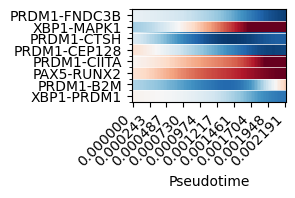

In [49]:
# plot the heatmap of the sign switching pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=sign_switching_pairs,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

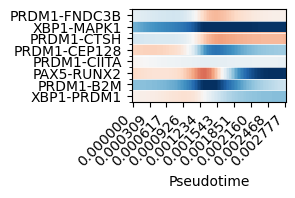

In [50]:
# plot the heatmap of the sign switching pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=sign_switching_pairs,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

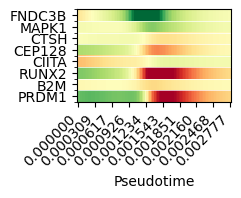

In [52]:
# get expression gradient of the sign switching pairs
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    genes_or_regulations=sign_switching_pairs,
    num=100,
    dist=0.0005,
    cmap='RdYlGn'
)

In [78]:
def get_top_20_filtered_pairs(pairs, metrics):
    # Create list of (pair, metrics) with multiple criteria
    filtered_pairs = []
    for pair, metric in zip(pairs, metrics):
        # Calculate a quality score
        quality_score = (
            metric['sign_changes'] * 1.0 +  # Primary weight on sign changes
            (metric['mean_diff'] > 0.1) * 0.5 +  # Bonus for large mean differences
            (metric['spread_diff'] > 0.05) * 0.3  # Bonus for large spread differences
        )
        filtered_pairs.append((pair, quality_score, metric))
    
    # Sort by quality score
    sorted_pairs = sorted(filtered_pairs, key=lambda x: x[1], reverse=True)
    
    # Print top 20 with their metrics
    print("\nTop 20 Filtered Pairs:")
    for pair, score, metric in sorted_pairs[:20]:
        print(f"\n{pair[0]} -> {pair[1]}")
        print(f"Sign changes: {metric['sign_changes']}")
        print(f"Mean difference: {metric['mean_diff']:.3f}")
        print(f"Spread difference: {metric['spread_diff']:.3f}")
        print(f"Quality score: {score:.3f}")
    
    return [pair for pair, _, _ in sorted_pairs[:20]]

# Use the function
top_20_filtered = get_top_20_filtered_pairs(sign_switching_pairs, metrics)


Top 20 Filtered Pairs:

KLF4 -> DUS1L
Sign changes: 15.0
Mean difference: 0.041
Spread difference: 0.068
Quality score: 15.300

PAX5 -> SRPK1
Sign changes: 14.0
Mean difference: 0.128
Spread difference: 0.094
Quality score: 14.800

NRF1 -> VEZF1
Sign changes: 14.0
Mean difference: 0.163
Spread difference: 0.021
Quality score: 14.500

REL -> CTH
Sign changes: 14.0
Mean difference: 0.127
Spread difference: 0.039
Quality score: 14.500

NRF1 -> EMC9
Sign changes: 14.0
Mean difference: 0.147
Spread difference: 0.008
Quality score: 14.500

NRF1 -> OSGEPL1-AS1
Sign changes: 14.0
Mean difference: 0.131
Spread difference: 0.019
Quality score: 14.500

PRDM1 -> BRCC3
Sign changes: 14.0
Mean difference: 0.037
Spread difference: 0.103
Quality score: 14.300

PRDM1 -> ZNF699
Sign changes: 13.0
Mean difference: 0.139
Spread difference: 0.065
Quality score: 13.800

NRF1 -> KDM2B
Sign changes: 13.0
Mean difference: 0.125
Spread difference: 0.080
Quality score: 13.800

PAX5 -> IDI2-AS1
Sign changes: 13.

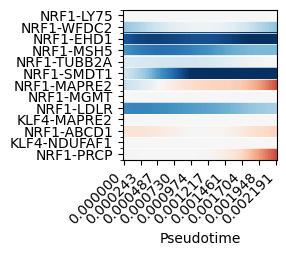

In [85]:
# plot the heatmap of the top 20 filtered pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=sign_switching_pairs,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

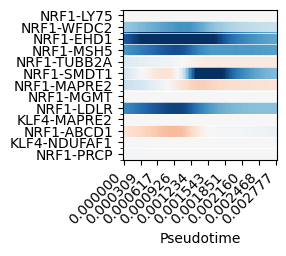

In [86]:
# plot the heatmap of the top 20 filtered pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=sign_switching_pairs,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

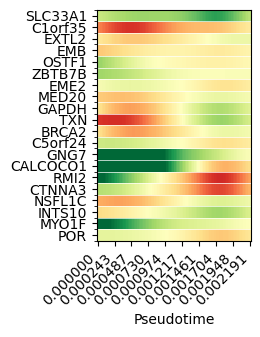

In [23]:
# get expression gradient of the top 20 filtered pairs
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    genes_or_regulations=top_20_filtered,
    num=100,
    dist=0.0005,
    cmap='RdYlGn'
)

#### Get divergent pairs by maximally selecting the highest abs diff

In [12]:
def get_divergent_pairs(pb_weights, gc_weights, tf_names, target_names, 
                       max_percentile=99.99, edge_presence_threshold=0.3, 
                       edge_strength_percentile=99.99):
    """
    Find TF-target pairs that show divergent regulation between PB and GC branches.
    """
    # Verify dimensions
    assert len(tf_names) == pb_weights.shape[0], "Number of TF names doesn't match weight matrix"
    assert len(target_names) == pb_weights.shape[1], "Number of target names doesn't match weight matrix"
    
    n_windows = min(pb_weights.shape[2], gc_weights.shape[2])
    
    # Calculate maximum absolute difference between branches
    branch_diff = np.abs(pb_weights[:, :, :n_windows] - gc_weights[:, :, :n_windows])
    max_divergence = np.max(branch_diff, axis=2)
    
    # Calculate edge presence in each branch
    pb_edge_presence = np.mean(pb_weights[:, :, :n_windows] != 0, axis=2)
    gc_edge_presence = np.mean(gc_weights[:, :, :n_windows] != 0, axis=2)
    
    # Calculate maximum absolute edge strength in each branch
    pb_max_strength = np.max(np.abs(pb_weights[:, :, :n_windows]), axis=2)
    gc_max_strength = np.max(np.abs(gc_weights[:, :, :n_windows]), axis=2)
    max_strength = np.maximum(pb_max_strength, gc_max_strength)
    
    # Set thresholds
    max_threshold = np.percentile(max_divergence[max_divergence > 0], max_percentile)
    strength_threshold = np.percentile(max_strength[max_strength > 0], edge_strength_percentile)
    
    # Find pairs that meet all criteria
    max_divergent = max_divergence >= max_threshold
    edge_present = (pb_edge_presence > edge_presence_threshold) & \
                  (gc_edge_presence > edge_presence_threshold)
    strong_edge = max_strength >= strength_threshold
    
    # Get indices of pairs that pass all filters
    tf_idx, target_idx = np.where(max_divergent & edge_present & strong_edge)
    # Get scores for sorting
    scores = max_divergence[tf_idx, target_idx]
    sort_idx = np.argsort(-scores)
    
    # Create two separate lists: pairs and scores
    filtered_pairs = []
    pair_scores = []
    for i in sort_idx:
        tf = tf_names[tf_idx[i]]
        target = target_names[target_idx[i]]
        score = scores[i]
        filtered_pairs.append((tf, target))
        pair_scores.append(score)
    return filtered_pairs, pair_scores


In [13]:
divergent_pairs, divergence_scores = get_divergent_pairs(
    lf_pb_weights, 
    lf_gc_weights,
    all_tf_names,
    all_target_names,
    max_percentile=10.00,
    edge_presence_threshold=0.3,
    edge_strength_percentile=10.00
)
# print the first 5 divergent pairs
display(divergent_pairs[:5])
display(divergence_scores[:5])

[(np.str_('STAT1'), np.str_('RFX5')),
 (np.str_('RELB'), np.str_('IRF4')),
 (np.str_('ATF3'), np.str_('PRDM1')),
 (np.str_('ELK1'), np.str_('E2F4')),
 (np.str_('FUBP1'), np.str_('CREM'))]

[np.float64(3.553696647656554),
 np.float64(2.137403360449401),
 np.float64(2.132877721040172),
 np.float64(2.048386607783556),
 np.float64(1.9171502637844)]

#### Get divergent edges by secleting strong edges that switch in a fraction of windows

In [80]:
def filter_by_edge_strength(pb_weights, gc_weights, tf_names, target_names,
                          edge_strength_percentile=99.99):
    """
    Filter edges by absolute strength threshold, requiring strong edges in both branches.
    Includes safety checks for edge cases.
    """
    n_windows = min(pb_weights.shape[2], gc_weights.shape[2])
    
    # Calculate maximum absolute edge strength in each branch
    pb_max_strength = np.max(np.abs(pb_weights[:, :, :n_windows]), axis=2)
    gc_max_strength = np.max(np.abs(gc_weights[:, :, :n_windows]), axis=2)
    
    # Get non-zero values for each branch
    pb_nonzero = pb_max_strength[pb_max_strength > 0]
    gc_nonzero = gc_max_strength[gc_max_strength > 0]
    
    # Safety check: if no non-zero values, return empty mask
    if len(pb_nonzero) == 0 or len(gc_nonzero) == 0:
        print("Warning: No non-zero values found in one or both branches")
        return np.zeros_like(pb_max_strength, dtype=bool), np.zeros_like(pb_max_strength)
    
    # Set threshold for each branch independently
    try:
        pb_threshold = np.percentile(pb_nonzero, edge_strength_percentile)
        gc_threshold = np.percentile(gc_nonzero, edge_strength_percentile)
    except IndexError:
        print("Warning: Not enough values to compute percentile")
        return np.zeros_like(pb_max_strength, dtype=bool), np.zeros_like(pb_max_strength)
    
    # Find pairs that meet strength criteria in both branches
    strong_edge_pb = pb_max_strength >= pb_threshold
    strong_edge_gc = gc_max_strength >= gc_threshold
    strong_edge = strong_edge_pb & strong_edge_gc
    
    # Store maximum strength across branches for reference
    max_strength = np.maximum(pb_max_strength, gc_max_strength)
    
    print(f"\nEdge Strength Filtering Statistics:")
    print(f"Total edges: {pb_weights.shape[0] * pb_weights.shape[1]:,}")
    print(f"Non-zero edges in PB: {len(pb_nonzero):,}")
    print(f"Non-zero edges in GC: {len(gc_nonzero):,}")
    print(f"Strong edges in PB (>{edge_strength_percentile}th percentile): {np.sum(strong_edge_pb):,}")
    print(f"Strong edges in GC (>{edge_strength_percentile}th percentile): {np.sum(strong_edge_gc):,}")
    print(f"Strong edges in both branches: {np.sum(strong_edge):,}")
    
    # Print thresholds for reference
    print(f"\nThresholds:")
    print(f"PB threshold: {pb_threshold:.4f}")
    print(f"GC threshold: {gc_threshold:.4f}")
    
    return strong_edge, max_strength

# Usage with more lenient percentile
strong_edge, max_strength = filter_by_edge_strength(
    lf_pb_weights,
    lf_gc_weights,
    all_tf_names,
    all_target_names,
    edge_strength_percentile=95.0  # Try a more lenient threshold
)

In [83]:
def get_switching_edges(pb_weights, gc_weights, tf_names, target_names, strong_edge,
                       diff_percentile=99.9, min_diff_windows=0.2, 
                       edge_presence_threshold=0.3):
    """
    Find edges that show significant differences between branches in a fraction of windows.
    Includes safety checks for edge cases.
    """
    n_windows = min(pb_weights.shape[2], gc_weights.shape[2])
    
    # Calculate absolute differences per window
    branch_diff = np.abs(pb_weights[:, :, :n_windows] - gc_weights[:, :, :n_windows])
    
    # Safety check: get non-zero differences
    nonzero_diffs = branch_diff[branch_diff > 0]
    if len(nonzero_diffs) == 0:
        print("Warning: No non-zero differences found between branches")
        return [], [], []
    
    # Calculate threshold for significant differences per window
    try:
        diff_threshold = np.percentile(nonzero_diffs, diff_percentile)
    except IndexError:
        print("Warning: Not enough values to compute difference percentile")
        return [], [], []
    
    # Find windows with significant differences
    significant_diff_windows = branch_diff >= diff_threshold
    
    # Calculate fraction of windows with significant differences
    diff_window_frac = np.mean(significant_diff_windows, axis=2)
    
    # Calculate edge presence
    pb_edge_presence = np.mean(pb_weights[:, :, :n_windows] != 0, axis=2)
    gc_edge_presence = np.mean(gc_weights[:, :, :n_windows] != 0, axis=2)
    edge_present = (pb_edge_presence > edge_presence_threshold) & \
                  (gc_edge_presence > edge_presence_threshold)
    
    # Find edges with sufficient different windows
    sufficient_diff = diff_window_frac >= min_diff_windows
    
    # Combine criteria
    switching_edges = sufficient_diff & edge_present & strong_edge
    
    # Safety check: if no edges pass criteria
    if not np.any(switching_edges):
        print("Warning: No edges pass all filtering criteria")
        return [], [], []
    
    # Get indices and scores
    tf_idx, target_idx = np.where(switching_edges)
    
    # Calculate scores based on both fraction and magnitude of differences
    max_diffs = np.max(branch_diff, axis=2)
    scores = diff_window_frac[tf_idx, target_idx] * max_diffs[tf_idx, target_idx]
    sort_idx = np.argsort(-scores)
    
    # Create filtered pairs and patterns
    filtered_pairs = []
    pair_scores = []
    switching_patterns = []
    
    for i in sort_idx:
        tf_i = tf_idx[i]
        target_i = target_idx[i]
        
        # Get the regulation patterns and differences
        pb_pattern = pb_weights[tf_i, target_i, :n_windows]
        gc_pattern = gc_weights[tf_i, target_i, :n_windows]
        diff_pattern = branch_diff[tf_i, target_i, :]
        
        # Get windows with significant differences
        sig_diff_windows = np.where(significant_diff_windows[tf_i, target_i])[0]
        
        filtered_pairs.append((tf_names[tf_i], target_names[target_i]))
        pair_scores.append(scores[i])
        switching_patterns.append({
            'pb_pattern': pb_pattern,
            'gc_pattern': gc_pattern,
            'diff_pattern': diff_pattern,
            'significant_windows': sig_diff_windows,
            'diff_window_frac': diff_window_frac[tf_i, target_i],
            'max_difference': max_diffs[tf_i, target_i]
        })
    
    print(f"\nSwitching Edge Statistics:")
    print(f"Edges with significant differences: {np.sum(sufficient_diff):,}")
    print(f"Edge present in both branches: {np.sum(edge_present):,}")
    print(f"Final pairs: {len(filtered_pairs):,}")
    
    # Print detailed results for top pairs
    if filtered_pairs:
        print("\nTop switching pairs:")
        for i, ((tf, target), score, pattern) in enumerate(zip(filtered_pairs, pair_scores, switching_patterns)):
            if i >= 10: break
            print(f"\n{tf} -> {target}")
            print(f"Fraction of significant windows: {pattern['diff_window_frac']:.2f}")
            print(f"Maximum difference: {pattern['max_difference']:.2f}")
            print(f"Significant windows: {pattern['significant_windows'].tolist()}")
    
    return filtered_pairs, pair_scores, switching_patterns

# Usage with more lenient thresholds
divergent_pairs, divergence_scores, switch_patterns = get_switching_edges(
    lf_pb_weights,
    lf_gc_weights,
    all_tf_names,
    all_target_names,
    strong_edge,
    diff_percentile=95.0,  # More lenient difference threshold
    min_diff_windows=0.2,
    edge_presence_threshold=0.3
)

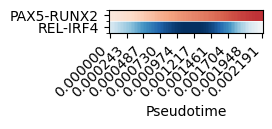

In [13]:
# plot the heatmap of the divergent pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=[('PAX5', 'RUNX2'),('REL','IRF4')],
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

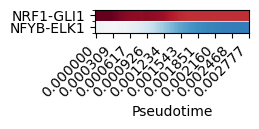

In [71]:
# plot the heatmap of the divergent pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=divergent_pairs,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

# Combinatorial Control of TFs

In [6]:
# get TF pairs from combinatorial control
tf_pairs_df = pd.read_csv(tf_pairs_file)
tf_pairs_and_targets = tf_pairs_df[['TF', 'common']]
display(tf_pairs_and_targets)

,TF,common
0,"('AFF1', 'IRF4')","{'PRDM1', 'AFF3', 'ANKRD28', 'ELL2', 'HSP90B1'}"
1,"('ATF5', 'CREB3L2')","{'FNDC3B', 'SEL1L3', 'BTG2', 'SLAMF7', 'ARFGAP..."
2,"('BACH2', 'EBF1')","{'JCHAIN', 'XBP1', 'MZB1'}"
3,"('BACH2', 'FLI1')","{'JCHAIN', 'XBP1', 'MZB1'}"
4,"('BACH2', 'FOSB')","{'JCHAIN', 'XBP1', 'MZB1'}"
...,...,...
145,"('XBP1', 'IRF4')","{'TXNDC11', 'FNDC3B', 'PRDM1', 'AFF3', 'JCHAIN..."
146,"('XBP1', 'TAF3')","{'HSP90B1', 'FNDC3B', 'TXNDC5'}"
147,"('ZBTB16', 'IRF4')","{'AFF3', 'HSP90B1'}"
148,"('ZBTB16', 'XBP1')","{'JCHAIN', 'HSP90B1'}"


In [7]:
all_tfs = []
for pair_str in tf_pairs_and_targets['TF']:
    tf1, tf2 = eval(pair_str)  # Convert string representation to actual tuple
    all_tfs.extend([tf1, tf2])  # Add both TFs to the list

# Get unique TFs using set
unique_tfs = sorted(set(all_tfs))

print(f"Number of unique TFs: {len(unique_tfs)}")
print("Unique TFs:", unique_tfs)

Number of unique TFs: 75
Unique TFs: ['AFF1', 'ARID5B', 'ATF5', 'BACH2', 'BATF3', 'BCL11A', 'BCL6', 'BHLHE22', 'BHLHE41', 'CHD1', 'CREB3L2', 'EBF1', 'EGR1', 'ESR1', 'FLI1', 'FOSB', 'FOSL1', 'FOXO1', 'HBP1', 'HERPUD1', 'HIVEP1', 'HIVEP2', 'HIVEP3', 'ID2', 'IKZF1', 'IRF4', 'IRF8', 'JUN', 'JUNB', 'KLF2', 'KLF4', 'L3MBTL4', 'MEF2A', 'MEF2C', 'NFATC2', 'NFKB1', 'NR6A1', 'NRF1', 'PAX5', 'PBX3', 'PBX4', 'PHF21A', 'PLAG1', 'PLAGL1', 'POLR2A', 'POU3F1', 'PRDM1', 'PTEN', 'REL', 'RFX3', 'RREB1', 'RUNX1', 'RUNX2', 'SMAD3', 'SOX4', 'SP3', 'STAT1', 'STAT4', 'TAF1', 'TAF3', 'TCF12', 'TCF4', 'TCFL5', 'TET3', 'TFDP2', 'TFEB', 'TFEC', 'TGIF1', 'XBP1', 'ZBTB16', 'ZBTB7A', 'ZFHX3', 'ZNF318', 'ZNF506', 'ZNF652']


In [8]:
# get unique targets by opening up the {} where all targets are stored and appending to a set
unique_targets = set()
for target_set in tf_pairs_and_targets['common']:
    unique_targets.update(eval(target_set))
unique_targets = sorted(unique_targets)
print(f"Number of unique targets: {len(unique_targets)}")
print("Unique targets:", unique_targets)


Number of unique targets: 23
Unique targets: ['AFF3', 'ANKRD28', 'ARFGAP3', 'BTG2', 'CD74', 'ELL2', 'FNDC3B', 'GLCCI1', 'HSP90B1', 'IRF4', 'JCHAIN', 'MED23', 'MZB1', 'PAX5', 'PDE4D', 'PRDM1', 'RUNX2', 'SEL1L3', 'SLAMF7', 'TRAM1', 'TXNDC11', 'TXNDC5', 'XBP1']


### Filtering TF-Target pairs based on edge significance

In [9]:
cc_tf_target_pairs = create_tf_target_pairs(dictys_dynamic_object, tf_pairs_and_targets)
display(cc_tf_target_pairs)

Created 196 unique TF-target pairs


[('NFKB1', 'CD74'),
 ('NFKB1', 'JCHAIN'),
 ('XBP1', 'PAX5'),
 ('BACH2', 'HSP90B1'),
 ('IRF4', 'JCHAIN'),
 ('BCL6', 'ELL2'),
 ('FOSL1', 'MZB1'),
 ('RREB1', 'SLAMF7'),
 ('SOX4', 'AFF3'),
 ('EGR1', 'GLCCI1'),
 ('TGIF1', 'TXNDC11'),
 ('JUNB', 'TXNDC11'),
 ('STAT4', 'SLAMF7'),
 ('IRF8', 'BTG2'),
 ('TGIF1', 'PAX5'),
 ('FLI1', 'IRF4'),
 ('FLI1', 'ELL2'),
 ('IRF8', 'TRAM1'),
 ('BACH2', 'PAX5'),
 ('PAX5', 'MED23'),
 ('SMAD3', 'XBP1'),
 ('HBP1', 'HSP90B1'),
 ('EGR1', 'FNDC3B'),
 ('NR6A1', 'TRAM1'),
 ('RUNX1', 'FNDC3B'),
 ('PBX3', 'PRDM1'),
 ('SP3', 'HSP90B1'),
 ('TFEB', 'TRAM1'),
 ('REL', 'MZB1'),
 ('NRF1', 'ELL2'),
 ('IRF8', 'TXNDC5'),
 ('NR6A1', 'SLAMF7'),
 ('NRF1', 'TXNDC11'),
 ('PAX5', 'GLCCI1'),
 ('IRF4', 'ELL2'),
 ('RUNX2', 'ELL2'),
 ('STAT1', 'MZB1'),
 ('RREB1', 'JCHAIN'),
 ('TFEB', 'TXNDC5'),
 ('MEF2C', 'SEL1L3'),
 ('PLAG1', 'MZB1'),
 ('NR6A1', 'PDE4D'),
 ('FLI1', 'PRDM1'),
 ('PAX5', 'FNDC3B'),
 ('FOSL1', 'JCHAIN'),
 ('STAT1', 'SLAMF7'),
 ('FLI1', 'FNDC3B'),
 ('NFKB1', 'GLCCI1'),
 ('FOSB

In [10]:
# Get unique TFs and targets from the pairs
tfs = sorted(set(pair[0] for pair in cc_tf_target_pairs))
targets = sorted(set(pair[1] for pair in cc_tf_target_pairs))

# Create DataFrame with TFs as rows and targets as columns
cc_tf_target_pairs_df = pd.DataFrame(0, index=tfs, columns=targets)

# Fill in the DataFrame with 1s for existing TF-target pairs
for tf, target in cc_tf_target_pairs:
    cc_tf_target_pairs_df.loc[tf, target] = 1

display(cc_tf_target_pairs_df)

,AFF3,ANKRD28,BTG2,CD74,ELL2,FNDC3B,GLCCI1,HSP90B1,IRF4,JCHAIN,...,PAX5,PDE4D,PRDM1,RUNX2,SEL1L3,SLAMF7,TRAM1,TXNDC11,TXNDC5,XBP1
BACH2,1,0,0,0,0,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,1
BATF3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
BCL6,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
EGR1,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ESR1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
FLI1,1,0,0,0,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
FOSB,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1
FOSL1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
FOXO1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HBP1,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Get the edge weights of TF-target pairs per branch

In [11]:
# now get the tf indices for the tfs in cc_tf_target_pairs
tf_indices_cc, _ = get_tf_indices(dictys_dynamic_object, tfs)
display(len(tf_indices_cc))

40

In [12]:
# get the gene indices for the targets in cc_tf_target_pairs
gene_indices_cc = get_target_gene_indices(dictys_dynamic_object, targets)
display(len(gene_indices_cc))
#display(gene_indices_cc)

22

#### Filter pairs based on branch sparsity and absolute edge weight

In [13]:
# get weights across windows
weights_tf_target_pb = get_weights_for_tf_target_pairs(dictys_dynamic_object, tf_indices_cc, gene_indices_cc, pb_window_indices)
weights_tf_target_gc = get_weights_for_tf_target_pairs(dictys_dynamic_object, tf_indices_cc, gene_indices_cc, gc_window_indices)

In [14]:
display(weights_tf_target_pb.shape)

(40, 22, 17)

In [15]:
display(np.max(weights_tf_target_pb))
display(np.min(weights_tf_target_pb))
display(np.max(weights_tf_target_gc))
display(np.min(weights_tf_target_gc))


np.float64(1.9487169016022052)

np.float64(-1.2820989402133387)

np.float64(2.042809333337349)

np.float64(-1.480683317811162)

#### GC branch

In [16]:
# Example usage
mask_gc = filter_tf_target_pairs(weights_tf_target_gc, 
                                      sparsity_threshold=0.99,  
                                      weight_percentile=90.00)
filtered_pairs_gc = get_filtered_pairs(mask_gc, tfs, targets, cc_tf_target_pairs)

# Get number of pairs that pass the filter
print(f"Number of filtered pairs: {len(filtered_pairs_gc)}")
display(filtered_pairs_gc)

Number of filtered pairs: 16


[('FLI1', 'IRF4'),
 ('FOXO1', 'AFF3'),
 ('JUNB', 'FNDC3B'),
 ('MEF2A', 'SEL1L3'),
 ('MEF2C', 'SEL1L3'),
 ('NFKB1', 'IRF4'),
 ('NRF1', 'AFF3'),
 ('NRF1', 'TXNDC11'),
 ('PAX5', 'MZB1'),
 ('REL', 'IRF4'),
 ('SOX4', 'AFF3'),
 ('STAT1', 'MZB1'),
 ('STAT1', 'SLAMF7'),
 ('TFEB', 'TRAM1'),
 ('TFEB', 'TXNDC5'),
 ('XBP1', 'HSP90B1')]

In [17]:
mask_pb = filter_tf_target_pairs(weights_tf_target_pb, 
                                      sparsity_threshold=0.9,  
                                      weight_percentile=99.00)   
filtered_pairs_pb = get_filtered_pairs(mask_pb, tfs, targets, cc_tf_target_pairs)

# Get number of pairs that pass the filter
print(f"Number of filtered pairs: {len(filtered_pairs_pb)}")
display(filtered_pairs_pb)

Number of filtered pairs: 12


[('ESR1', 'PRDM1'),
 ('FOXO1', 'AFF3'),
 ('MEF2A', 'SEL1L3'),
 ('MEF2C', 'SEL1L3'),
 ('NFKB1', 'IRF4'),
 ('NRF1', 'TXNDC11'),
 ('PAX5', 'MZB1'),
 ('REL', 'IRF4'),
 ('STAT1', 'MZB1'),
 ('STAT1', 'SLAMF7'),
 ('TFEB', 'TRAM1'),
 ('XBP1', 'PRDM1')]

In [18]:
# create a list of tuples with pairs of pax5 coming from both branches, accounting for duplicates
filtered_pairs_all = list(set(filtered_pairs_pb + filtered_pairs_gc))
display(len(filtered_pairs_all))

18

In [20]:
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=filtered_pairs_all,
    num=100,  # Number of points to interpolate
    dist=0.0005,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    cmap='RdBu',  # Red indicates higher values, Blue indicates lower values
    figsize=(2, 0.2),  # Reduced row height to 0.15
)

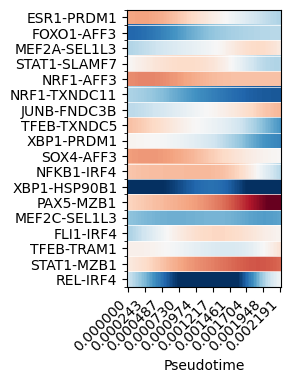

In [30]:
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=filtered_pairs_all,
    num=100,  # Number of points to interpolate
    dist=0.0005,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    cmap='RdBu',  # Red indicates higher values, Blue indicates lower values
    figsize=(2, 0.2),  # Reduced row height to 0.15
)

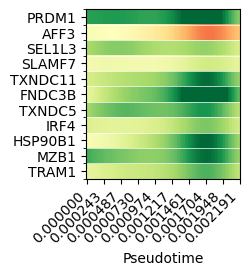

In [31]:
# Example usage:
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdYlGn', # Red = negative gradient, Yellow = neutral, Green = positive gradient
    figsize=(2, 0.2)
)

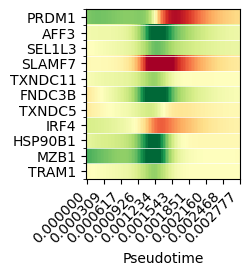

In [32]:
# Example usage:
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdYlGn', # Red = negative gradient, Yellow = neutral, Green = positive gradient
    figsize=(2, 0.2)
)

### Sub-GRN of particular TF

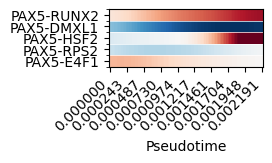

In [27]:
# draw the heatmap of the filtered pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=pax5_filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

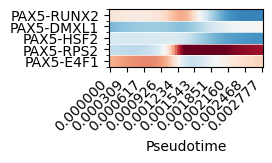

In [28]:
# draw the heatmap of the filtered pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=pax5_filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

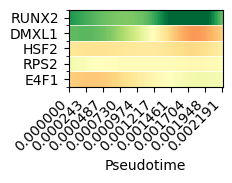

In [30]:
# Example usage:
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=pax5_filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdYlGn', # Red = negative gradient, Yellow = neutral, Green = positive gradient
    figsize=(2, 0.2)
)

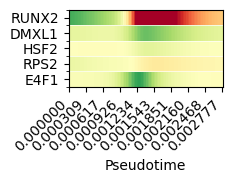

In [31]:
# Example usage:
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=pax5_filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdYlGn', # Red = negative gradient, Yellow = neutral, Green = positive gradient
    figsize=(2, 0.2)
)

### Window labels

In [6]:
# get the proportion of cell types in each window
cell_labels_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/data/clusters.csv'
#read the columns barcodes and cluster
cell_labels_df = pd.read_csv(cell_labels_file, index_col=0)
cell_labels = cell_labels_df['Cluster']

In [45]:
# get the top 3 states from window 1,4,5
top_3_states_40 = get_top_k_fraction_labels(dictys_dynamic_object, 40, cell_labels, k=3)
display(top_3_states_40)
sorted_states = sorted(top_3_states_40, key=lambda x: x[1][1], reverse=True)

/ocean/projects/cis240075p/asachan/bio_informatics_analysis/B_Cells_human_analysis/analysis_repo/multiome_dynamic_regulation/py_scripts/analysis/utils_custom.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state_labels_in_window[window_idx] = [cell_labels[idx] for idx in indices_of_cells_present_in_window]


[('ActB-4', (0.7909090909090909, 0.7837837837837838)),
 ('earlyPB', (0.11545454545454545, 0.7732115677321156)),
 ('PB-2', (0.04659090909090909, 0.08742004264392324))]

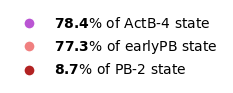

In [46]:
# Create custom legend handles and labels
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

leiden_color_dict = {
    'ActB-1': 'lightskyblue',     # light blue cluster at bottom
    'ActB-2': 'dodgerblue',       # darker blue cluster
    'ActB-4': 'mediumorchid',     # purple cluster
    'GC-1': 'limegreen',          # bright green cluster
    'ActB-3': 'darkblue',         # dark blue cluster
    'Naive': 'darkgray',          # gray cluster on left
    'GC-2': 'green',              # darker green cluster
    'PB-2': 'firebrick',          # red cluster
    'earlyPB': 'lightcoral',      # pink/coral cluster
    'earlyActB': 'teal'           # teal cluster
}
# Create custom legend handles and labels
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=leiden_color_dict[state[0]], 
           markersize=8, label=f'$\\mathbf{{{state[1][1]*100:.1f}}}$% of {state[0]} state')
    for state in sorted_states
]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 2))  # Adjusted figure size for vertical layout
ax.set_visible(False)  # Hide the axis

# Add the legend to the figure vertically
fig.legend(handles=legend_elements, 
          loc='center', 
          ncol=1,  # Changed to 1 column for vertical layout
          frameon=False)

plt.tight_layout()
plt.show()

# Animations

In [5]:
branches={
	'Plasmablast':(1,2),
	'Germinal-center':(1,3)
}
#Value range for coloring
vrange={
	'Terminal logFC':[-4,4],
	'Transient logFC':[-4,4],
	'Switching time':[0.0015,0.0045],
}

for branchname in branches:
	print(branchname)
	figs=dictys_dynamic_object.draw_discover(*branches[branchname],num=100,dist=0.0005,vrange=vrange)
	plt.show()

Plasmablast


In [6]:
from IPython.display import FileLink
from dictys.plot import layout,panel
# Number of frames (interpolated time points/equispaced time points), use 100 or higher for finer resolution
nframe=10
# Animation FPS for saving. Determines speed of play
fps=0.10*nframe
# DPI for animation
dpi=100


In [7]:
branchname='Plasmablast'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['PAX5']
]
# Select TFs for each row's other plots
tfs_ann=[
	['XBP1','PRDM1','NRF1', 'PAX5']
]
# Select genes to annotate as targets in all rows
target_ann=['RUNX2','MZB1','PRDM1','PAX5', 'IRF4']


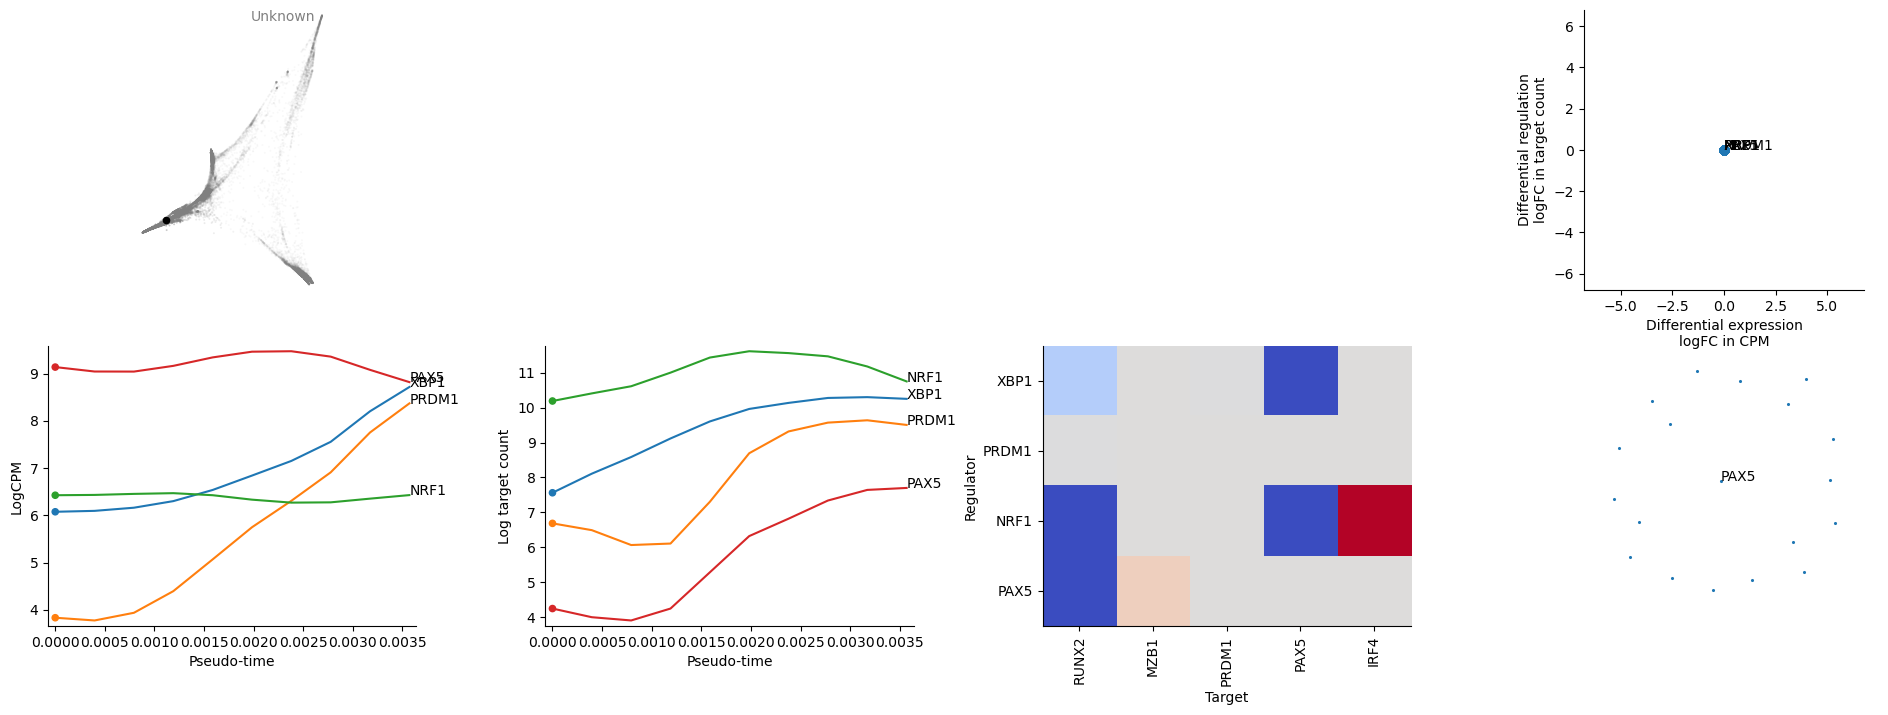

In [8]:
branch=branches[branchname]
# initialize layout with dist, n_points, dpi
layout1=layout.notch(dist=0.0005,nframe=nframe,dpi=dpi)
pts,fig,panels,animate_ka=layout1.draw(
	dictys_dynamic_object,branch,
	# Set genes to annotate
	bcde_tfs=tfs_ann,e_targets=target_ann,f_tfs=tfs_subnet,
	# Custom legend location for long cell type name
	a_ka={'scatterka':{'legend_loc':(0.6,1)}},
	# Custom configurations for color range
	e_ka={'lim':[-0.02,0.02]},
)
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(**animate_ka)


In [9]:
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,codec='h264')
w.frame_format='jpeg'
fo=f'/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/animation-10-{branchname}.mp4'
anim.save(fo,writer=w,dpi='figure')
display(FileLink(fo))


/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/animation-10-Plasmablast.mp4